In [4]:
import os
import cv2
import  PIL
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torch.nn.functional as F 
from matplotlib import pyplot as plt
from torchvision import transforms
from IPython.display import display, Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(os.listdir(r"D:\FACULTY OF AI , YEAR 3\CV MINA\PROJECT\Dataset"))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [5]:
labels_df = pd.read_csv(r"D:\FACULTY OF AI , YEAR 3\CV MINA\PROJECT\labels.csv")
labels_df

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [6]:
num_classes = 43
images = []
labels = []

for class_label in range(num_classes):
    class_dir = os.path.join(r"D:\FACULTY OF AI , YEAR 3\CV MINA\PROJECT\Dataset", str(class_label))

    for filename in os.listdir(class_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            img_path = os.path.join(class_dir, filename)
            image = cv2.imread(img_path , cv2.IMREAD_COLOR) 
            image = cv2.resize(image, (32,32))
            images.append(image)
            labels.append(class_label)

images = torch.tensor(images)
labels = torch.tensor(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: torch.Size([34780, 32, 32, 3])
Labels shape: torch.Size([34780])


C:\Users\Nos7Y\AppData\Local\Temp\ipykernel_13128\3227857144.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  images = torch.tensor(images)


# balancing the data

In [7]:
images = images.reshape(images.shape[0],3*32*32) # flatten images as RandomOverSampler only accepts 2-D matrix
# RandomOverSampler method duplicates samples in the minority class to balance dataset
images,labels = RandomOverSampler().fit_resample(images,labels)
images = images.reshape(images.shape[0],3,32,32) # reshaped again as it was
images.shape, labels.shape

((86430, 3, 32, 32), (86430,))

In [8]:
np.unique(labels,return_counts=True)  #ensuring


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64),
 array([2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
        2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
        2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
        2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010],
       dtype=int64))

# **preprocessing**

In [9]:
class ImagePreprocessor:
    def __init__(self, image):
        self.image = image
#-------------------------------------------------------------------------------------------    
    def resize_image(self, size=(255, 255)):
        self.image = cv2.resize(self.image, size)
        return self.image 
#-------------------------------------------------------------------------------------------  
    def convert_to_grayscale(self):
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        return self.image
#-------------------------------------------------------------------------------------------    
    def reduce_noise(self):
        self.image = cv2.GaussianBlur(self.image, (5, 5), 0)
        return self.image
#-------------------------------------------------------------------------------------------
    def enhance_contrast(self):
        if len(self.image.shape) == 3:  # Check if the image is BGR
            lab = cv2.cvtColor(self.image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            lab = cv2.merge((cl, a, b))
            self.image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return self.image
#-------------------------------------------------------------------------------------------    
    def normalize_image(self):
        self.image = self.image / 255.0 if self.image.dtype != np.float32 else self.image
        self.image = (self.image * 255).astype(np.uint8)  # Convert back to uint8
        return self.image
#-------------------------------------------------------------------------------------------    
    def brighten_image(self, alpha=1.0, beta=50):
        self.image = cv2.convertScaleAbs(self.image, alpha=alpha, beta=beta)
        return self.image

# **Segmentation**

### local thresholding 

In [7]:
def local_thresholding(image):
    _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

### automatic thresholding

In [8]:
def automatic_thresholding(image, block_size=15):
    rows, cols = image.shape
    result = np.zeros_like(image)
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i + block_size, j:j + block_size]
            threshold = np.mean(block)
            result[i:i + block_size, j:j + block_size] = (block > threshold).astype(np.uint8) * 255
    return result


### CHOW and KANEKO

In [9]:
def chow_kaneko(image, block_size=15):
    rows, cols = image.shape
    result = np.zeros_like(image)

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i + block_size, j:j + block_size]
            threshold = np.mean(block)
            result[i:i + block_size, j:j + block_size] = (block > threshold).astype(np.uint8) * 255

    return result


### cheng jin kuo

In [10]:
def cheng_jin_kuo(image, block_size=15, k=0.5):
    rows, cols = image.shape
    result = np.zeros_like(image)
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i + block_size, j:j + block_size]
            local_mean = np.mean(block)
            local_std = np.std(block)
            threshold = local_mean - k * local_std
            result[i:i + block_size, j:j + block_size] = (block > threshold).astype(np.uint8) * 255
    return result


# **Feature Extraction**

### Shape-Based Features (Hough Transform)

In [11]:
def detect_shapes(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)

    # Detect circles (e.g., round traffic signs)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=100)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(image, (x, y), r, (0, 255, 0), 2)

    return image


### Local Feature Descriptors (SIFT, ORB)

In [12]:
def extract_local_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    return image_with_keypoints, keypoints, descriptors


### Edge Detection (Canny Edge)

In [13]:
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges


### Blob Detection (LoG)

In [14]:
def detect_blobs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(gray)
    
    image_with_blobs = cv2.drawKeypoints(image, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return image_with_blobs

# ___________________________________________________________

In [10]:
# Ensure proper shapes before creating dataset
images = torch.tensor(images, dtype=torch.float32)  # Convert to float tensor
labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long type

# Create dataset and data loaders
dataset = TensorDataset(images, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
class EnhancedCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1, bias=True)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, bias=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=1, bias=True)
        self.bn3 = nn.BatchNorm2d(16)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool1(nn.ReLU(inplace=True)(self.bn1(self.conv1(x))))
        x = self.avgpool1(nn.ReLU(inplace=True)(self.bn2(self.conv2(x))))
        x = self.maxpool2(nn.ReLU(inplace=True)(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(nn.ReLU(inplace=True)(self.fc1(x)))
        x = self.fc2(x)
        return x
    


In [12]:
model = EnhancedCNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


EnhancedCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=43, bias=True)
)

In [13]:
def train_model(model, optimizer, train_loader, criterion, device='cuda', num_epochs=5):
    model.to(device)  # Move the model to the appropriate device
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to the device
            images, labels = images.to(device).float(), labels.to(device).long()
            
            # If needed, permute or fix channel dimensions
            if images.shape[-1] == 3:  # If channels are the last dimension
                images = images.permute(0, 3, 1, 2)
            if images.shape[1] > 3:  # If more than 3 channels, take first 3
                images = images[:, :3, :, :]

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Training complete!


In [11]:
train_model(model, optimizer, train_loader, criterion, device='cuda', num_epochs=10)


Epoch [1/10], Loss: 1.5034
Epoch [2/10], Loss: 0.5834
Epoch [3/10], Loss: 0.4330
Epoch [4/10], Loss: 0.3602
Epoch [5/10], Loss: 0.3162
Epoch [6/10], Loss: 0.2858
Epoch [7/10], Loss: 0.2611
Epoch [8/10], Loss: 0.2414
Epoch [9/10], Loss: 0.2196
Epoch [10/10], Loss: 0.2142


In [14]:
def test_model(model, data_loader):
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for images, targets in data_loader:

            images, targets = images.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            # Update loss and predictions
            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
            
    avg_val_loss = val_loss / len(data_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_precision = precision_score(val_targets, val_preds, average='weighted')
    val_recall = recall_score(val_targets, val_preds, average='weighted')
    val_f1 = f1_score(val_targets, val_preds, average='weighted')

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, "
        f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

In [13]:
test_model(model, test_loader)

Validation Loss: 0.0919, Accuracy: 0.9730, Precision: 0.9735, Recall: 0.9730, F1: 0.9731


In [15]:
def prediction(img):
    if type(img) == str:
        # PIL load the image as PIL object and ToTensor() convert this to a Tensor
        img = tv.transforms.ToTensor()(PIL.Image.open(img))
    # resize image to 32X32 as model supports this
    img = cv2.resize(img.permute(1,2,0).numpy(),(32,32))
    img = torch.from_numpy(img).permute(2,0,1)
    # unsqueezed img as inside a tensor and move to cuda
    img_tensor = img.unsqueeze(0).to(torch.device('cuda'))
    # Predict the label
    pred = int(model(img_tensor).argmax(axis=1)[0])
    # Find the traffic sign name for label from labels_df 
    # that initialize at the begining of the notebook
    pred_str = labels_df[labels_df['ClassId'] == pred]['Name'][pred]
    # Show the image using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.resize(img.permute(1,2,0).numpy(),(1000,1000)))
    plt.axis('off')
    # Print traffic sign that recognized
    print('\nRecognized Traffic Sign :',pred_str,'\n')


Recognized Traffic Sign : Speed limit (80km/h) 



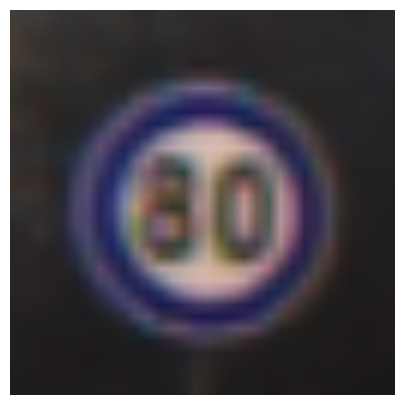

In [18]:
prediction(r"D:\FACULTY OF AI , YEAR 3\CV MINA\PROJECT\Dataset\5\5_12556_1577672001.4824204.png")
